In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

In [2]:
#!pip install keras
#!pip install tensorflow

In [3]:
df = pd.read_csv('aggregate_data.csv')
df

,date,close,high,low,open,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 10:18:00+05:30,131339.90,131375.10,131302.53,131325.13,609188,131324.612,131343.600,131382.266000,131407.0495,...,4242.451361,5139.981011,4543.348734,4284.915034,-4773.161292,139.259557,75.72,131339.176667,2391.521163,21.041367
1,2015-02-02 10:19:00+05:30,131303.61,131368.07,131268.38,131342.64,693540,131322.022,131338.209,131365.417333,131399.8400,...,4211.623197,3954.944584,4468.296823,4303.308823,-4942.009553,136.546017,101.27,131313.353333,2370.485111,18.040339
2,2015-02-02 10:20:00+05:30,131248.36,131321.94,131217.80,131300.96,1610837,131303.796,131328.486,131348.264667,131388.6160,...,3862.393006,2840.307256,3978.410951,4115.856089,-5387.322962,134.329159,105.51,131262.700000,2351.023435,16.246702
3,2015-02-02 10:21:00+05:30,131257.97,131304.23,131209.05,131243.00,934932,131294.402,131315.095,131336.512000,131378.0600,...,3527.549677,3419.157833,3404.803225,4190.866180,-5136.397490,131.636362,96.63,131257.083333,2328.956512,28.036258
4,2015-02-02 10:22:00+05:30,131297.42,131329.43,131222.76,131257.06,1012966,131289.452,131307.606,131329.189333,131367.3655,...,3783.520863,4982.998418,3747.487836,4378.816472,-4275.330925,129.867336,106.87,131283.203333,2304.101743,23.595730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639976,2022-10-24 19:10:00+05:30,260762.30,260861.80,260619.30,260764.20,1338179,260701.840,260676.380,260732.273333,260756.1000,...,5812.817423,5723.215673,6339.296397,4900.557475,-3776.821766,276.233018,246.95,260747.800000,1888.976858,24.784875
639977,2022-10-24 19:11:00+05:30,260751.35,260898.20,260615.20,260788.30,1268550,260737.590,260673.490,260727.350000,260751.0125,...,5692.451293,4952.129379,5659.698669,4938.590525,-3853.783316,276.719945,283.05,260754.916667,1895.574295,28.911954
639978,2022-10-24 19:12:00+05:30,260810.85,260929.15,260631.85,260778.65,2678132,260766.770,260682.455,260725.903333,260748.2900,...,5574.213174,4522.644499,5065.996517,5315.854811,-3811.398143,278.307806,298.95,260790.616667,1895.013164,23.481135
639979,2022-10-24 19:13:00+05:30,260856.45,260979.45,260677.20,260822.40,1435058,260787.580,260699.140,260725.496667,260749.5525,...,5493.144531,5228.295344,4901.023074,5279.008055,-3460.688845,280.082248,303.15,260837.700000,1896.095788,12.334048


In [12]:
df['date'] = pd.to_datetime(df['date']).dt.date
df.sort_values(by='date',ascending=False)
df = df.groupby(["date"]).mean()
df

,close,high,low,open,volume,sma5,sma10,sma15,sma20,ema5,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
date,,,,,,,,,,,,,,,,,,,,,
2015-02-02,131288.958237,131349.417179,131229.601955,131286.480705,9.137327e+05,131284.209006,131278.897301,131274.004613,131269.574686,131284.381505,...,4185.103972,4349.078852,4347.786014,4243.926555,-4569.996794,123.060885,123.854199,131289.325791,1856.672161,29.413975
2015-02-03,131832.877280,131918.827600,131747.429387,131837.580720,9.363481e+05,131841.322645,131851.470080,131861.067426,131870.462753,131841.190402,...,4201.208571,4267.691967,4266.097873,4349.520327,-4624.607800,175.531286,177.491147,131833.044756,1850.806014,32.266154
2015-02-04,129468.922827,129537.612613,129402.188933,129471.623013,8.874415e+05,129480.442459,129493.245917,129505.959004,129518.131477,129480.170210,...,4282.346297,4365.674560,4366.273596,4309.880640,-4478.144418,143.180905,143.231867,129469.574791,1810.422482,32.472286
2015-02-05,129249.723173,129317.821493,129181.671733,129248.157733,8.532143e+05,129247.353024,129246.376232,129246.078405,129246.293272,129247.729483,...,4360.040253,4370.202737,4371.174798,4390.548113,-4422.675177,142.086475,142.190373,129249.738800,1866.926771,34.137286
2015-02-06,127985.717387,128065.870400,127915.340693,127994.159200,8.134050e+05,127991.635936,127998.763027,128006.067154,128013.714268,127991.612995,...,4281.577005,4405.903914,4408.064297,4285.640985,-4514.621708,158.384781,157.028987,127988.976160,1823.159505,31.149459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18,257670.968933,257762.494267,257573.920533,257667.477867,1.282223e+06,257658.191600,257642.305253,257626.159902,257609.747993,257658.237257,...,4499.256233,4368.839149,4368.606377,4539.692614,-4285.578336,194.228740,192.962267,257669.127911,1870.897240,31.214918
2022-10-19,259022.745291,259126.470914,258917.889751,259022.869252,1.205348e+06,259017.145346,259010.896482,259004.666168,258999.158276,259017.359822,...,4352.005184,4314.598961,4309.073554,4457.055028,-4545.111346,210.245498,212.275762,259022.368652,1858.772147,33.578715
2022-10-20,258462.879837,258558.429564,258354.404360,258454.714441,1.418727e+06,258457.465041,258450.504946,258443.347339,258436.162589,258457.371907,...,4693.187218,4486.951088,4482.975267,4586.587346,-4009.046383,207.505872,208.260763,258458.571253,1925.554930,35.505967


In [13]:
df1 = df.reset_index()['close']
#df1 = df1.head(100000)
df1

0       131288.958237
1       131832.877280
2       129468.922827
3       129249.723173
4       127985.717387
            ...      
1764    257670.968933
1765    259022.745291
1766    258462.879837
1767    259788.447905
1768    260920.830000
Name: close, Length: 1769, dtype: float64

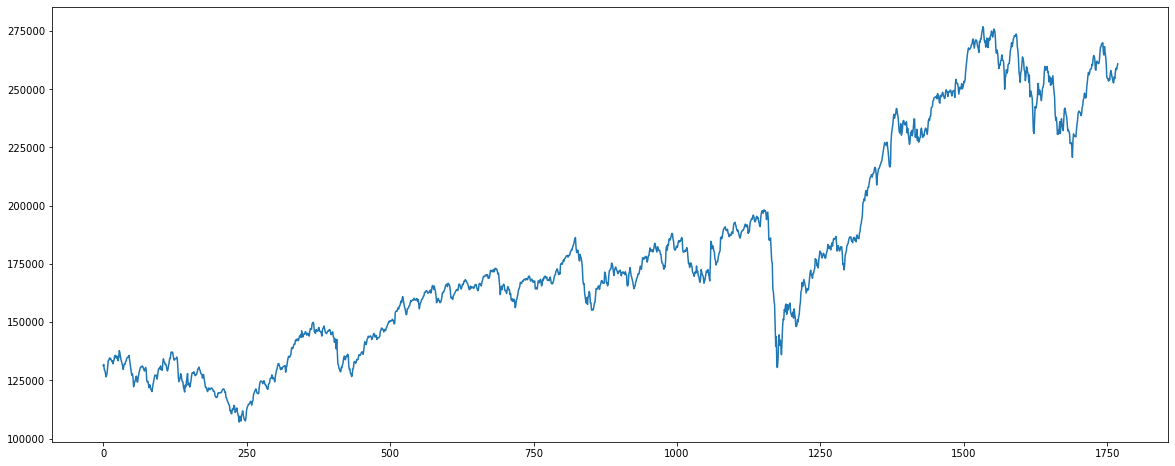

In [14]:
plt.figure(figsize=(20,8))
plt.plot(df1)

In [15]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
training_size=int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [17]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [20]:
X_train.shape[1]

100

In [21]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [23]:
model.fit(X_train, y_train, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
21/21 [==============================] - 6s 89ms/step - loss: 0.0077
Epoch 2/20
21/21 [==============================] - 2s 91ms/step - loss: 0.0257
Epoch 3/20
21/21 [==============================] - 2s 90ms/step - loss: 0.0134
Epoch 4/20
21/21 [==============================] - 2s 91ms/step - loss: 0.0029
Epoch 5/20
21/21 [==============================] - 2s 92ms/step - loss: 0.0019
Epoch 6/20
21/21 [==============================] - 2s 90ms/step - loss: 0.0022
Epoch 7/20
21/21 [==============================] - 2s 92ms/step - loss: 0.0021
Epoch 8/20
21/21 [==============================] - 2s 90ms/step - loss: 0.0023
Epoch 9/20
21/21 [==============================] - 2s 88ms/step - loss: 0.0017
Epoch 10/20
21/21 [==============================] - 2s 90ms/step - loss: 0.0023
Epoch 11/20
21/21 [==============================] - 2s 89ms/step - loss: 0.0017
Epoch 12/20
21/21 [==============================] - 2s 90ms/step - loss: 0.0024
Epoch 13/20
21/21 [==================

In [24]:
test_predict = model.predict(X_test)

8/8 [==============================] - 1s 21ms/step


In [25]:
print(f'MSE {mean_squared_error(y_test, test_predict)}')
print(f'R2 {r2_score(y_test, test_predict)}')

MSE 0.006245505006416921
R2 -0.020393627386238178


In [26]:
test_predict= scaler.inverse_transform(test_predict)
train_predict = model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

42/42 [==============================] - 1s 21ms/step


In [27]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

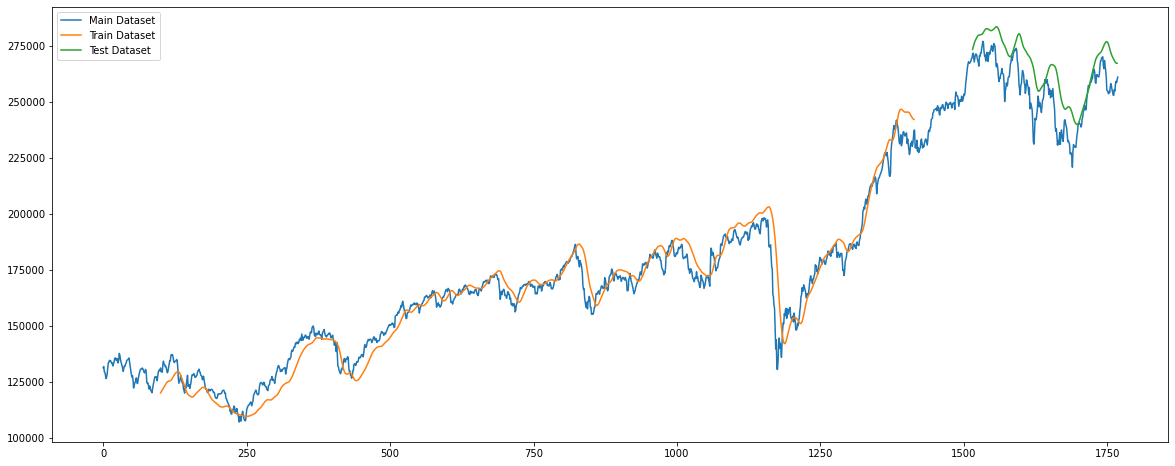

In [28]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label = 'Main Dataset')
plt.plot(trainPredictPlot, label = 'Train Dataset')
plt.plot(testPredictPlot, label = 'Test Dataset')
plt.legend()

In [29]:
x_input = df1[len(df1)-100:].reshape(1,-1)

In [30]:
x_input = x_input.reshape((1,100,1))
y_predict = model.predict(x_input, verbose = 0)
next_day_value = scaler.inverse_transform(y_predict)

In [31]:
next_day_value

array([[267404.5]], dtype=float32)